** Import Necessary Libraries**

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings('ignore')

**Load the Data**

In [49]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [51]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)


Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


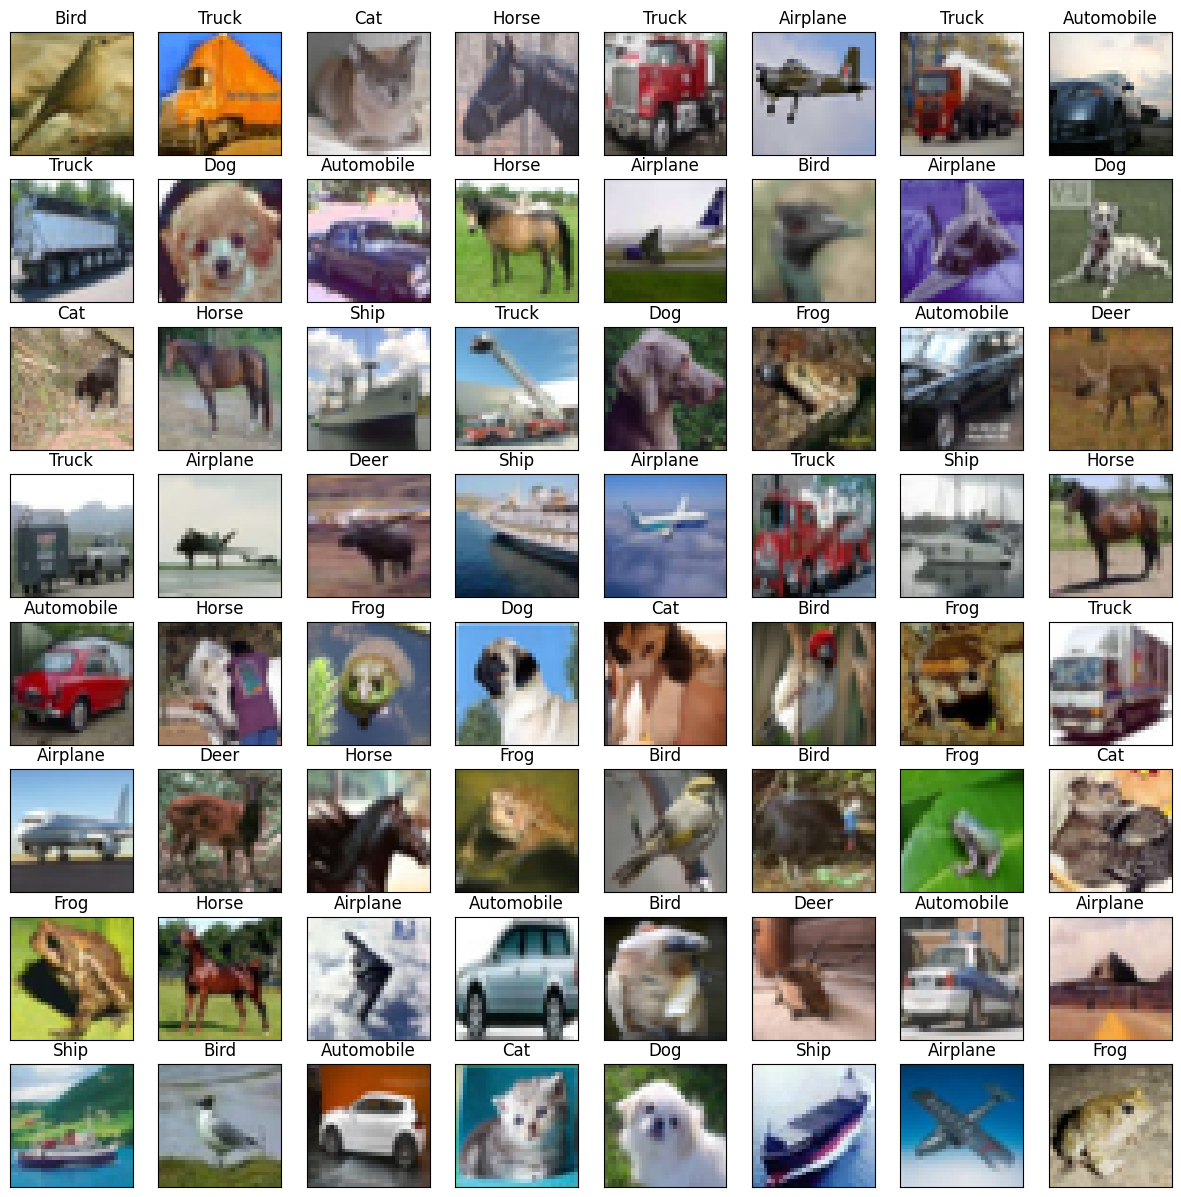

In [52]:
# CIFAR-10 classes
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

** Preprocess the data**

In [75]:
# Preprocess the data
def preprocess_data(y):
    # X = X.astype('float32') / 255.0  # Normalize to [0, 1]
    y = to_categorical(y, num_classes=10)  # One-hot encode labels
    return y

In [78]:
y_train = preprocess_data(y_train)
y_valid = preprocess_data(y_valid)
y_test = preprocess_data(y_test)

In [79]:
y_train[:5]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [54]:
# X_train, y_train = preprocess_data(X_train, y_train)
# X_valid, y_valid = preprocess_data(X_valid, y_valid)
# X_test, y_test = preprocess_data(X_test, y_test)

In [55]:
# # Create data generator for augmentation
# gen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True


# )
# gen.fit(X_train)

In [74]:
y_train[:5], y_valid[:5]

(array([[2],
        [9],
        [3],
        [7],
        [9]], dtype=uint8),
 array([[7],
        [5],
        [5],
        [6],
        [5]], dtype=uint8))

In [80]:

# Define ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [81]:
#freeze base model layers
base_model.trainable = True

In [82]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu') ,
    Dense(10, activation='softmax')

])

In [84]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor the validation loss
    patience=3,                   # Patience of 3 epochs (i.e., stop after 3 epochs of no improvement)
    restore_best_weights=True     # Restore the weights of the best epoch
)


In [86]:
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,146,442 (92.11 MB)

 Trainable params: 24,093,322 (91.91 MB)

 Non-trainable params: 53,120 (207.50 KB)

array([[[177, 168, 119],
        [171, 162, 113],
        [162, 154, 103],
        ...,
        [149, 128,  81],
        [141, 120,  72],
        [155, 135,  82]],

       [[186, 175, 128],
        [179, 167, 120],
        [173, 160, 113],
        ...,
        [175, 154,  99],
        [185, 164, 108],
        [195, 175, 116]],

       [[184, 167, 113],
        [177, 162, 110],
        [173, 160, 110],
        ...,
        [207, 184, 126],
        [204, 183, 122],
        [203, 181, 120]],

       ...,

       [[101,  91,  51],
        [ 65,  61,  24],
        [ 88,  81,  33],
        ...,
        [ 51,  45,  26],
        [ 51,  41,  23],
        [ 49,  39,  22]],

       [[ 77,  65,  33],
        [ 61,  56,  23],
        [103,  96,  42],
        ...,
        [ 47,  43,  26],
        [ 53,  45,  27],
        [ 50,  43,  25]],

       [[108,  93,  53],
        [126, 108,  58],
        [134, 116,  58],
        ...,
        [ 47,  43,  21],
        [ 64,  57,  29],
        [ 74,  63,  32]]], dtype=uint8)
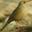

In [87]:
X_train[0]


In [63]:
y_train[0]

array([2], dtype=uint8)

In [90]:
X_train.shape, y_train.shape

((45000, 32, 32, 3), (45000, 10))

In [89]:
X_valid.shape, y_valid.shape

((5000, 32, 32, 3), (5000, 10))

In [88]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 10, 10))

In [91]:
history = model.fit(
    X_train, y_train,

    batch_size=64,
    epochs=15,  # Limit the number of epochs
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]  # Pass early stopping callback
)


Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 113s 77ms/step - accuracy: 0.4595 - loss: 1.6722 - val_accuracy: 0.4872 - val_loss: 2.0789
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.6752 - loss: 1.0092 - val_accuracy: 0.3166 - val_loss: 2.8575
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.6857 - loss: 0.9527 - val_accuracy: 0.6210 - val_loss: 1.2420
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.7432 - loss: 0.7852 - val_accuracy: 0.7126 - val_loss: 0.8441
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.7831 - loss: 0.6649 - val_accuracy: 0.7182 - val_loss: 0.8943
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.7938 - loss: 0.6370 - val_accuracy: 0.6024 - val_loss: 1.2411
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.7982 - loss: 0.6212 - val_accuracy: 0.6930 - val_loss: 0.9962


In [95]:
# Preprocess the test data
X_test = X_test.astype('float32') / 255.0  # Normalize to [0, 1]
y_test = to_categorical(y_test, num_classes=10)  # One-hot encode labels

In [96]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 10, 10, 10), output.shape=(None, 10)

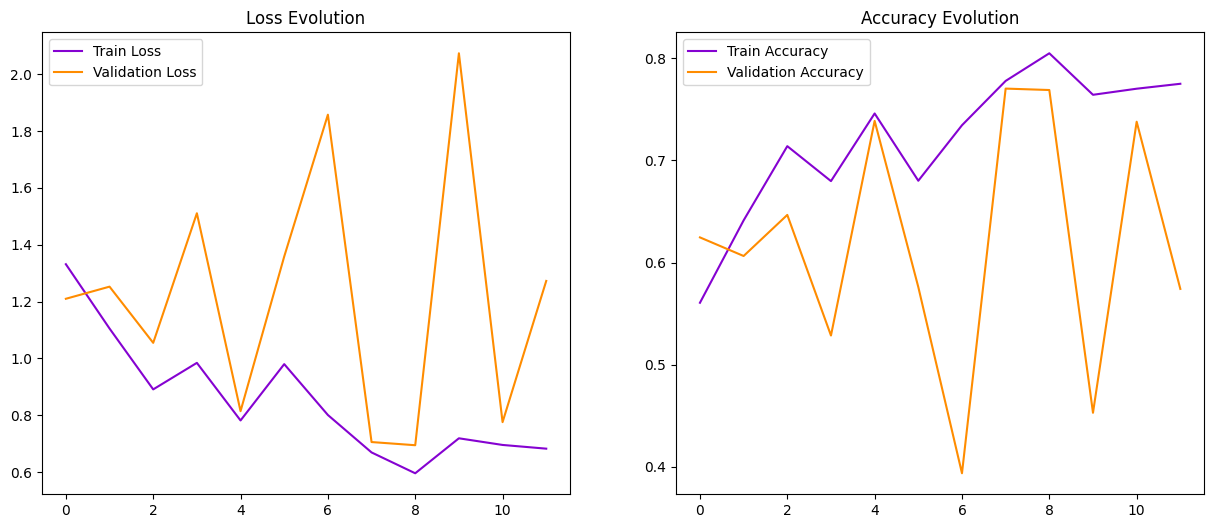

In [69]:

# Make sure the training history has been captured
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
# Flatten the true labels for the classification report
y_test_flat = np.argmax(y_test, axis=1)

In [ ]:
# Generate classification report
report = classification_report(y_test_flat, y_pred_classes, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
])
print("Classification Report:\n", report)